In [13]:
##Analysis Version
#This version goes fast over the conversions and raw results, and is more intended for 
#(adding) analysis and #plotting

#This is an example script for the use of the PointConcentration class/object for pointconcentration measurements
#from the windtunnel python package, showing the use of almost all available analysis functions
# The columns in the input file are expected to be time, wtref, slow FID, fast ID, release signal and open_rate, 
# where release signal will be ignored.
#Net_concentration, entdimensionalized concentration c_star and full_scale concentration full_scale_concentration u
#will be generated using the PointConcentration class and functions
#The PointConcentration class is a python class/object saving all of the menditory values and results for the calculation
#It returns a DataFrame,
#Needed inputs are the paths to raw ts series folder, the name of the prefix of all ts
#Path and name to parameter csv file incorporating the parameters needed(As specificied in example cell second below for the analysis standard measurement
#Finally the output path can be specified as well as the saving options (just concentration time series,averages, statistic for all time series
#Or combined file

#Path and file names
#INPUT 
path_dir = "/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare"
#Path to your input data
#path = f"{path_dir}/ExampleData/InputData/Concentration/"
path = f"{path_dir}/ExampleData/InputData/Beispiel Umrechnung zur Kontrolle/"
#path = f"/home/sabrina/Schreibtisch/Arbeit_2025/Nora_test/"
# Name of your measurement files prefix
#namelist = ['BFS_BD3_MP01_000']
namelist = ['UBA_GA_02_04_01_000_1_001'] #['UBA_thesis'] 
#Path to your output folder for average files and plots
output_path = f"{path_dir}/ExampleData/Results/"
#For PointData for the functions to work the columns of the file should be: time, wtref, slow_FID, fast_FID, open_rate
#(See manual for the description of the variables)
#Name of csv file which contains ambient conditions data. Multiple diff. ambient conditions for diff datasets can be read-in at ones
#If no file given or configuration wrong, the program ressorts to try reading-in given values manually below. 
#csv_file='ambient_conditions.csv'
#csv_file= f"{path_dir}/ExampleData/ParameterFiles/ambient_conditions.csv"
csv_file= f"{path_dir}/ExampleData/ParameterFiles/ambient_conditions_.UBA_GA.csv"
#csv_file= f"{path}ambient_conditions_point1.csv"
parameters_PerFolder = False

#Variables and Parameters set for all ts, if no ambient_conditions.csv file overgiven
#If at the end calculate entdimensionalised or full scale transform quantities
#Default: nd:entdimensionalise, ms:model scale, fs:full scale.    
full_scale='ms'
#Postprocessing before analysis
applyPostprocessing=True
averageInterval=60 #s  #Interval to downaverage raw time series to before analysis
measurementFreq=0.005 #Time series frequency #For now only for static case implemented
averagingColumns=["net_concentration"] #Columns to average dow
#Saving settings: (output_path for path)
osType = "Linux" #Windows  #For Path
outputName = None #Default: ts name

saveTs=True    #Only save time series of concentration quantities to separat files
saveAvg=True #Save average of ts of concentration quantities to separat files
saveStats=True #Save averages, percentile95/5, peak2mean of ts of concentration quantities to separat files
saveCombined=True #Save all averages and statistics for all files to one combined file
combinedFileName="combined_file_nora.csv"
base_path=None #base_path = output_path + "Files/Point_Data_stats/UBA_thesi/" # Base path for getting files for combined files, if None

saveAll=True #Sets saveTs, saveAvg and saveStats, saveCombined to True, saving ts, averages, statistics and combined file

#Overgive uncertainty
uncertainty_value=None #Uncertainty of concentration, has to be calculated/estimated from the experimentator
#If None overgive no error visualized as errorbars 0.5
uncertainty_representation="percentage" #"absoluteValue"

In [14]:
#Example file/Default environment values if no csv_file found:

#Source location  [mm]
x_source=0
y_source=0
z_source=0
#Source mass flow controller, calibration settings
mass_flow_controller=0.300 #0.600#Stickstoffdurchflussregler #[l/h]*1/100 #'X'  #Controller(settings) used, just a name placeholder for orientation, not used yet
#If calibration performed on a controller, corrects actual max. flow capacity of controller
calibration_curve=1.0     #0.3     #0.3 oder 3
calibration_factor=0 #1      #
#Gas characteristics
gas_name='C12'           #Just placeholder name variable for orientation, not used for anything
gas_factor=0.5   #[-]    #!!! Needs to be calculate/specificate f.e. if gas changes 
mol_weight=29.0 #28.97 #Air [g/mol]
#Measurement location [mm]
x_measure=1020 #855.16
y_measure= 0    #176.29
z_measure= 5     #162
#Surrounding conditions
pressure=101426.04472        #1009.38  #[hPa] ->Pa
temperature=23             #23.5  #[°C]
#Model to Reality scaling
scale=400                     #250      #Model/Reality
scaling_factor=0.5614882               #0.637       #USA1 to selected ref pos.?
ref_length=1/400              #1/250           #Lref
ref_height=100/400            #None            #Href
#Full Scale Parameters
full_scale_wtref=10             #6         #Uref_fullscale
full_scale_flow_rate=0.002     #Q_amb[kg/s]?   #0.5   #Qv_fullscale
full_scale_temp=20             #[°C]
full_scale_pressure=101325     #[Pa]
#Q_ambient[kg/s] ->  Q[m³/s]=Q[kg/s]*R*T/(M*p)
#Variable wdir for wind direction. To be implemented in future. ##
#wdir=0
#Variable axis_range. Reserved for future implementation of axis range specification, 
#analogously to puff mode
#axis_range='auto'


In [15]:
#Imports
import windtunnel as wt
import os
import sys
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from windtunnel.concentration.CompareDatasets import *

#Edited Nora: Check if ambient conditions file is even there, before trying out reading-in
print(f"CSV erwartet unter: {csv_file}")
if os.path.exists(csv_file):
    print("✅ CSV-Datei gefunden.")
else:
    print("❌ CSV-Datei NICHT gefunden.")
    print("Folgende Dateien sind im Ordner vorhanden:")
    for f in os.listdir(path):
        print(f)
        
###### Initialise concentration ts dictionary of length namelist, as well as for full scale and entdimensionalised
conc_ts = {}
conc_ts.fromkeys(namelist)
conc_ts_fs = conc_ts
conc_ts_nd = conc_ts

dict_conc_ts = conc_ts
dict_conc_nd = conc_ts
dict_conc_fs = conc_ts

data_dict = {}
data_dict.fromkeys(namelist)

#Read in ambient conditions for each folder or concentration ts from given csv file or for same conditions from manually
parameters_PerFolder = parameters_PerFolder #False  #True=for each folder/namelist entry new column, False: for each ts one column entry

for name in namelist:
    files = wt.get_files(path, name)
    print(f"files: {files}")

    #Initilise Dictionary for each given name containing dimensions of nr of files ts#0-
    conc_ts[name] = {}
    conc_ts[name].fromkeys(files)
    
    if parameters_PerFolder==True:
        #Read ambient conditions from csv file only for each folder
        ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=name, input_file=csv_file)
        #print(ambient_conditions)
        #Else read/use given default from cell above
        if ambient_conditions is None:
            []
        #Read ambient conditions from csv file
        else:
            x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
            ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure, config_name = wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, name)
            
        
    for file in files:
        if parameters_PerFolder == False:
            #Read in ambient condition column for each ts
            ambient_conditions = wt.PointConcentration.get_ambient_conditions(path=path, name=file, input_file=csv_file)
            #Else read/use given default from cell above
            if ambient_conditions is None:
                []
            #Read ambient conditions from csv file
            else:
                x_source, y_source, z_source, x_measure, y_measure, z_measure, pressure, temperature, calibration_curve, mass_flow_controller, calibration_factor, scaling_factor, scale, ref_length, \
                ref_height, gas_name, mol_weight, gas_factor, full_scale_wtref, full_scale_flow_rate, full_scale_temp, full_scale_pressure,  config_name= wt.PointConcentration.read_ambient_conditions(
                ambient_conditions, file)

        conc_ts[name][file] = wt.PointConcentration.from_file(path + file)
    
        conc_ts[name][file].ambient_conditions(x_source=x_source, y_source=y_source, z_source=z_source,
                                               x_measure=x_measure, y_measure=y_measure, z_measure=z_measure,
                                               pressure=pressure,
                                               temperature=temperature,
                                               calibration_curve=calibration_curve,
                                               mass_flow_controller=mass_flow_controller,
                                               calibration_factor=calibration_factor,
                                               config_name=config_name)

        #Set read-in scaling, gas and full scale information to internal class variables
        print("Store information into PointConcentration class objects array")
        conc_ts[name][file].scaling_information(scaling_factor=scaling_factor, 
                                                scale=scale,
                                                ref_length=ref_length, 
                                                ref_height=ref_height)
        conc_ts[name][file].tracer_information(gas_name=gas_name,
                                               mol_weight=mol_weight,
                                               gas_factor=gas_factor)
        conc_ts[name][file].full_scale_information(full_scale_wtref=full_scale_wtref,
                                                   full_scale_flow_rate=full_scale_flow_rate,
                                                   full_scale_temp=full_scale_temp,full_scale_pressure=full_scale_pressure)

        #Calculate mass flow rate, net concentration and dimensionalise concentration
        print("Do main calculations")
        conc_ts[name][file].convert_temperature()
        conc_ts[name][file].calc_wtref_mean()
        
        conc_ts[name][file].calc_model_mass_flow_rate(usingMaxFlowRate="True",applyCalibration="False")
        conc_ts[name][file].calc_net_concentration()

        #conc_ts[name][file].clear_zeros()  #Remove values net_concentration =< 0 from dataset !noise
        conc_ts[name][file].calc_c_star()

        conc_ts[name][file].calc_full_scale_concentration() #Try

        #Transforming/Outputting data in full-scale, model scale, and non-dimensional
        print("Transform scale")
        if full_scale == 'ms':
            dict_conc_ts = conc_ts
            
        elif full_scale == 'fs':
            dict_conc_ts = conc_ts_fs
            dict_conc_ts[name][file].to_full_scale()
            
        elif full_scale == 'nd':
            dict_conc_ts = conc_ts_nd
            dict_conc_ts[name][file].to_non_dimensional()
        else:
            print(
                "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")
        #Apply Postprocessing if overgiven
        """
        measurementFreq=measurementFreq #Time series frequency #For now only for static case implemented
        averageInterval=averageInterval #60 #s
        columns=averagingColumns #Columns to average down
        #print(len(dict_conc_ts[name][file].net_concentration))
        if(applyPostprocessing==True):
                print("Apply postprocessing averaging: {averageInterval}s")
                dict_conc_ts[name][file].downAverage(averageInterval=averageInterval,measurementFreq=measurementFreq, columns=columns)
                #dict_conc_ts[name][file].net_concentration
        
        #print(len(dict_conc_ts[name][file].net_concentration))
        """
        #Saving PointConcObject calculates new quantities(f.e. c*star) to files
        if(saveAll):
            saveTs=True
            saveAvg=True
            saveStats=True
            saveCombined=True
        if(saveCombined):
            saveAvg=True
            saveStats=True
                    
        if(saveTs==True or saveAvg==True or saveStats==True or saveCombined==True):
            if osType=="Windows":
                folder = 'Point_Data\\' + name[:name.find('.')] + '\\'
                folder_avg = 'Point_Data_avg\\' + name[:name.find('.')] + '\\'
                folder_stats = 'Point_Data_stats\\' + name[:name.find('.')] + '\\'
            elif osType=="Linux":
                 #print("gets here 2")
                 folder = 'Files/' + 'Point_Data/' + name[:name.find('.')] + '/'
                 folder_avg = 'Files/' + 'Point_Data_avg/' + name[:name.find('.')] + '/'
                 folder_stats = 'Files/' + 'Point_Data_stats/' + name[:name.find('.')] + '/'
              
            wt.check_directory(output_path + folder)
            dict_conc_ts[next(iter(conc_ts))][next(iter(conc_ts[next(iter(conc_ts))]))].__check_sum = 8
        #dict_conc_ts[name][file].__check_sum = 8
      
        if(saveTs):
            if full_scale == 'ms':
                dict_conc_ts[name][file].save2file_ms(file, out_dir=output_path + folder)
            elif full_scale == 'fs':
                dict_conc_ts[name][file].save2file_fs(file, out_dir=output_path + folder)
            elif full_scale == 'nd':
                dict_conc_ts[name][file].save2file_nd(file, out_dir=output_path + folder)
            else:
                print(
                    "Error: invalid input for full_scale. Data can only be computed in model scale (full_scale='ms'), full scale (full_scale='fs'), or non-dimensionally (full_scale=nd).")
                exit
            print("Created ts files including (net_concentration, entimendionsliased and full scale concentration)")
        if(saveAvg):
             #Saving averages to files under folder Point_Data_stats/
            #Averages of net_concentration,c_star and full_scale_concentration
             wt.check_directory(output_path + folder_avg)
             dict_conc_ts[name][file].save2file_avg(file, out_dir=output_path + folder_avg)
             print(f"Created avg files under {output_path + folder_avg}")
        if(saveStats):
            #Saving stats to files under folder Point_Data_avg/
            #Stats Full ausgabe: saveAvg Quantities + Percentile 95, percentile 5, peak2Mean of net_concentration_c_star and full_Scale_conc
             wt.check_directory(output_path + folder_stats)
             dict_conc_ts[name][file].save2file_fullStats(file, out_dir=output_path + folder_stats)
             print(f"Created stats files under {output_path + folder_stats}")
            
        if(saveCombined):
            from windtunnel.concentration.utils import *
            #normal test
            stats=True
            if(stats):
                file_type="stats"
            #stats test
            #file_names = [
            #    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#0",
            #    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#1",
            #    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#2",
            #    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#3",
            #    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#4",
            #    r"Point_Data_stats\UBA_GA_02_04_01_000_1_00\_stats_UBA_GA_02_04_01_000_1_001.txt.ts#5"
            #]
            #base_path =output_path
            #base_path = output_path + "Files/Point_Data_avg/UBA_GA_02_04_01_000_1_00"
            #base_path = output_path + "Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/"
            file_names = ["_stats_" + file for file in files]
            if(base_path==None):
                #base_path = output_path + "Files/Point_Data_stats/UBA_thesi/"
                base_path = output_path + f"Files/Point_Data_{file_type}/{name[0:-1]}/"
            #combine_to_csv(file_names, base_path, file_type='avg', output_filename=output_path+'combined_data.csv')
            combine_to_csv(file_names, base_path, file_type=file_type, output_filename=output_path+combinedFileName)
            #print(f"Created combined file under{output_path + combinedFileName}")

            
    

CSV erwartet unter: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/ParameterFiles/ambient_conditions_.UBA_GA.csv
✅ CSV-Datei gefunden.
files: ['UBA_GA_02_04_01_000_1_001.txt.ts#0', 'UBA_GA_02_04_01_000_1_001.txt.ts#1', 'UBA_GA_02_04_01_000_1_001.txt.ts#2', 'UBA_GA_02_04_01_000_1_001.txt.ts#3', 'UBA_GA_02_04_01_000_1_001.txt.ts#4', 'UBA_GA_02_04_01_000_1_001.txt.ts#5']
Store information into PointConcentration class objects array
Do main calculations
Transform scale


/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref


Created ts files including (net_concentration, entimendionsliased and full scale concentration)
Created avg files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_avg/UBA_GA_02_04_01_000_1_00/
Created stats files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/
Processing 6 stats files
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UBA_GA_02_04_01_000_1_001.txt.ts#0
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UBA_GA_02_04_01_000_1_001.txt.ts#1
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UB

/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref


Created ts files including (net_concentration, entimendionsliased and full scale concentration)
Created avg files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_avg/UBA_GA_02_04_01_000_1_00/
Created stats files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/
Processing 6 stats files
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UBA_GA_02_04_01_000_1_001.txt.ts#0
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UBA_GA_02_04_01_000_1_001.txt.ts#1
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UB

/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref


Created ts files including (net_concentration, entimendionsliased and full scale concentration)
Created avg files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_avg/UBA_GA_02_04_01_000_1_00/
Created stats files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/
Processing 6 stats files
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UBA_GA_02_04_01_000_1_001.txt.ts#0
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UBA_GA_02_04_01_000_1_001.txt.ts#1
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UB

/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/w

Created ts files including (net_concentration, entimendionsliased and full scale concentration)
Created avg files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_avg/UBA_GA_02_04_01_000_1_00/
Created stats files under /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/
Processing 6 stats files
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UBA_GA_02_04_01_000_1_001.txt.ts#0
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UBA_GA_02_04_01_000_1_001.txt.ts#1
Processing: /home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/ExampleData/Results/Files/Point_Data_stats/UBA_GA_02_04_01_000_1_00/_stats_UB

/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.time = time
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:65: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.open_rate = open_rate
/home/sabrina/Desktop/Schreibtisch/Arbeit_2025/WTSoftwareUtilitiesShare/windtunnel/concentration/PointConcentration.py:66: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.wtref = wtref



 File: UBA_GA_02_04_01_000_1_001.txt.ts#0
c_star vorhanden
C_star shape: (30000,)
NaNs vorhanden: False
Min/Max: -0.30316299999999985 / 1202.017763
Mean: 57.80034634370001
Std: 57.766640161132536
Percentiles: {10: 12.215996500000001, 90: 120.00919130000001, 95: 161.68999759999997}

 File: UBA_GA_02_04_01_000_1_001.txt.ts#1
c_star vorhanden
C_star shape: (30000,)
NaNs vorhanden: False
Min/Max: -1.1505290000000001 / 779.15148
Mean: 57.68628691473333
Std: 61.95945048114293
Percentiles: {10: 9.1554916, 90: 125.9157658000001, 95: 173.63429904999998}

 File: UBA_GA_02_04_01_000_1_001.txt.ts#2
c_star vorhanden
C_star shape: (30000,)
NaNs vorhanden: False
Min/Max: -0.621735 / 795.289011
Mean: 52.02871467456667
Std: 57.61027356225919
Percentiles: {10: 7.128442400000001, 90: 116.657799, 95: 158.66340479999997}

 File: UBA_GA_02_04_01_000_1_001.txt.ts#3
c_star vorhanden
C_star shape: (30000,)
NaNs vorhanden: False
Min/Max: -0.8273609999999999 / 814.549495
Mean: 47.412503647
Std: 51.9680188034305

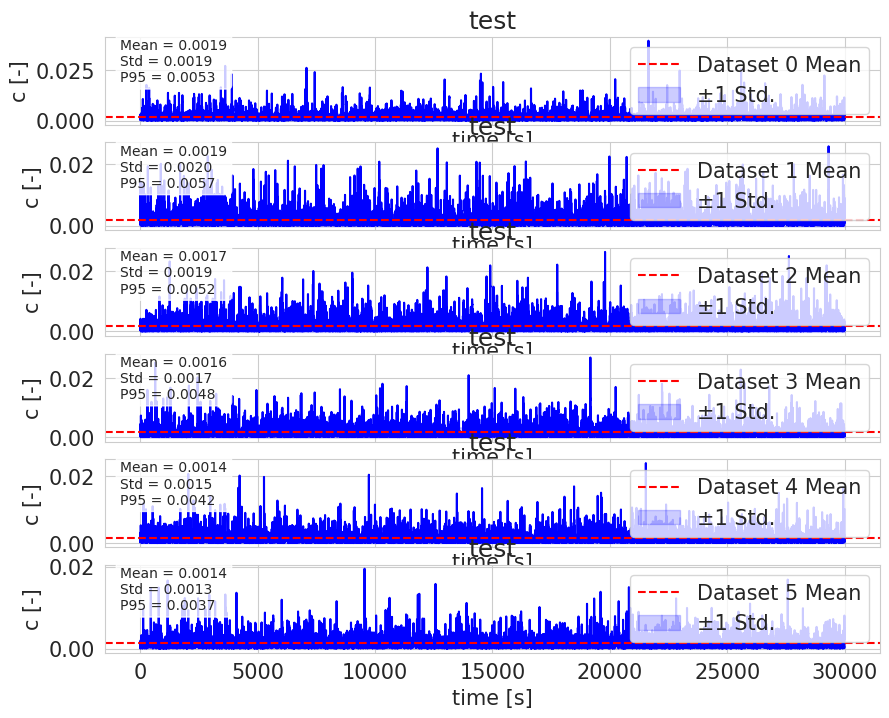

In [16]:
#Test read-in and net_conc and c*star output values, shape, nans and min/max
#Test if net_concentration and c_star there
"""if hasattr(conc_ts[name][file], "c_star"):
    print("c_star vorhanden")
else:
    print("⚠️ Keine c_star Daten gefunden.")

if hasattr(conc_ts[name][file], "concentration"):
    if hasattr(conc_ts[name][file], "net_concentration"):
        setattr(conc_ts[name][file], "concentration", conc_ts[name][file].net_concentration)
    else:
        print("⚠️ Kein concentration oder net_concentration gefunden.")"""

 
#Test numerical value range
for name in namelist:
    for file in files:
        print(f"\n File: {file}")
        if hasattr(conc_ts[name][file], "c_star"):
            print("c_star vorhanden")
        else:
            print("⚠️ Keine c_star Daten gefunden.")

        print("C_star shape:", conc_ts[name][file].net_concentration.shape)
        #print(conc_ts[name][file].net_concentration)
        #plt.plot(conc_ts[namelist[0]][files[0]].c_star)
        print("NaNs vorhanden:", np.any(np.isnan(conc_ts[name][file].net_concentration)))
        print("Min/Max:", np.min(conc_ts[name][file].net_concentration), "/", np.max(conc_ts[name][file].net_concentration))
        print(f"Mean: {np.mean(conc_ts[name][file].net_concentration)}")
        print(f"Std: {np.std(conc_ts[name][file].net_concentration)}")
        print(f"Percentiles: {conc_ts[name][file].calc_percentiles(percentiles=[10, 90, 95], var='net_concentration')}")    
plt.show()
#plt.violinplot([conc_ts[name][file].c_star for file in files])
#plt.show()


#Read-in Data into separat array for later plotting (files/series can also be specifically choosen)
dimensionless=True
color="blue"

DataPointsConc = []
#DataPointsConc = [ conc_ts[namelist[0]]["MyFileofInterest1.txt"], conc_ts[namelist[0]]["MyFileofInterest2.txt"]]
for i in range(len(files)): #Just visualising all
    data = conc_ts[namelist[0]][files[i]]
    DataPointsConc.append(data)
# Richtige Zeitserien laden
labels=[f"Dataset {i}" for i in range(0,len(DataPointsConc))]
plot_timeseries_with_stats(DataPointsConc,dimensionless=dimensionless,labels=labels,color=color)

In [5]:
"""
#full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"
full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"
base_path = output_path + "Files/Point_Data_avg/UBA_thesi/"
file_names = ["_avg_" + file for file in files]
for file in file_names:
    #metadata = {}
    data = []
    with open(full_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            if line.startswith('"'):
                # Kopfzeile mit Variablennamen
                headers = line.replace('"', '').split()
                continue
            # Wertezeile
            values = list(map(float, line.split()))
            data.append(values)
    
    df = pd.DataFrame(data, columns=headers)
    print(df.head())
"""

'\n#full_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"\nfull_path = "/Users/norakaiser/Masterthesis/WTSoftwareUtilitiesShare/test_meas/results/Point_Data_avg/UBA_thesis_test_01072025_001/_avg_UBA_thesis_test_01072025_001.ts#0"\nbase_path = output_path + "Files/Point_Data_avg/UBA_thesi/"\nfile_names = ["_avg_" + file for file in files]\nfor file in file_names:\n    #metadata = {}\n    data = []\n    with open(full_path, \'r\') as f:\n        for line in f:\n            line = line.strip()\n            if not line or line.startswith(\'#\'):\n                continue\n            if line.startswith(\'"\'):\n                # Kopfzeile mit Variablennamen\n                headers = line.replace(\'"\', \'\').split()\n                continue\n            # Wertezeile\n            values = list(map(float, line.split()))\n            data.append(values)\n    \n    df = pd.Dat

[191.1711425166667, 46.59676312166666, 14.19278708866667, 7.925406690666662, 0.021087820083330655]
[129.70314641666664, 31.181590431666663, 10.847684875000006, 6.899539998166674, 1.772200359583323]
[141.5670969333333, 32.77503943666666, 9.870075067333325, 4.920635326166661, 0.9165446198333385]
[110.15718923333336, 27.162796098333324, 7.330642992333345, 5.694779225000005, 3.859295252999999]
[79.68427418333333, 21.704997195000004, 7.134927745333329, 4.667101114333327, 2.873633315083339]
[76.71157831666667, 19.92285522166666, 7.927559724666658, 4.380431845333327, 0.9446214741666665]


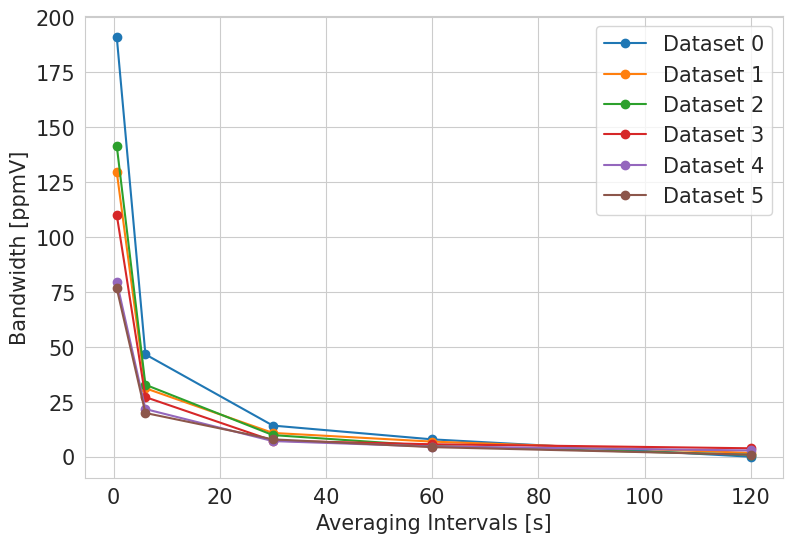

In [17]:
#Bandwidth convergence plot
xLabel = "Time Interval"
yLabel = "Windspeed [m/s]"
Labels = None
dimensionless = True #False
xAchse = None
yAchse = None
error_values = 0.1
marker = 'o'
#colors = ["green",""blue"]
time_freq = 0.010 #s
averaging_intervals = [60*0.01,60*0.1,60*0.5,60*1.0,60*2.0]# [60*0.01,60*0.1,60*0.5, 60*1,60*2,60*3,60*4,60*5]#in s     #Example for [15,30 and 60 min]
#t*[[-] =[s/(m/s) * m]  = t[s] / Uref[m/s] * Lref[m]
#TODO:Bandwidth=True

bandwidths = []
for name in namelist:
    for file in files:
        ts_v_avg = conc_ts[name][file].get_averagedData(name, file, time_freq, averaging_intervals)
        bandwidths.append([np.max(avg) - np.min(avg) for avg in ts_v_avg])  # or use np.ptp(avg)(peakTopeak) for same result, but faster
for i, bandwidth in enumerate(bandwidths):
    print(bandwidth)
    plt.plot(averaging_intervals, bandwidth, "o-", 
             label=f"Dataset {i}" if Labels is None else Labels[i])
plt.xlabel("Averaging Intervals [s]")
plt.ylabel("Bandwidth [ppmV]")
plt.legend()
plt.grid(True)
plt.show()

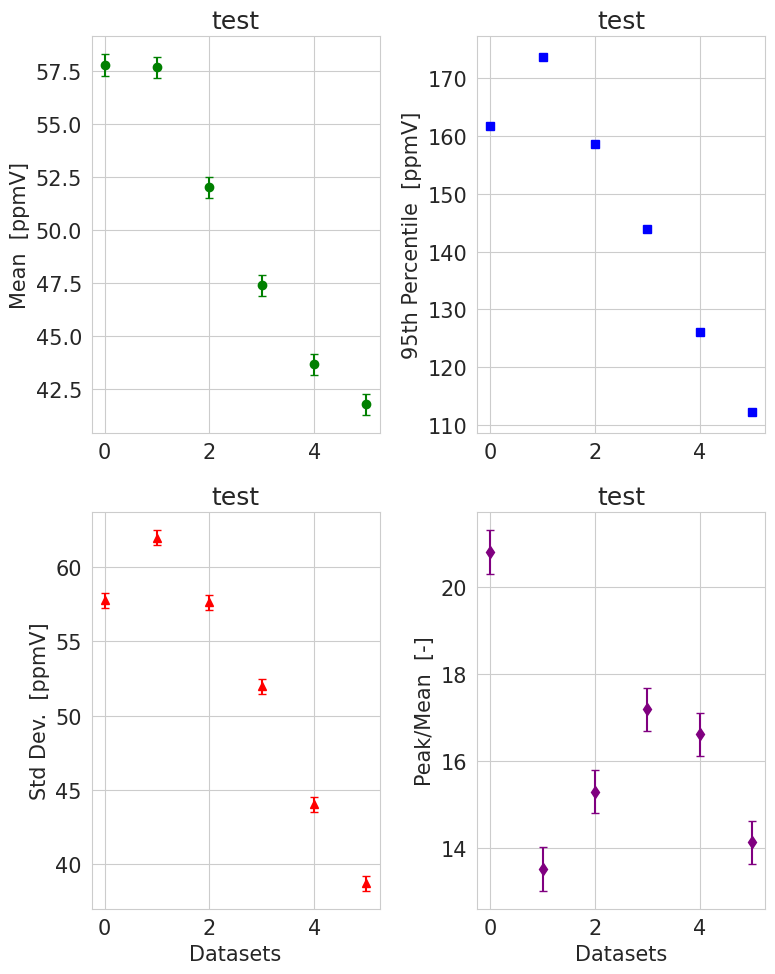

In [12]:
#4x1 Table means, std., peak2mean,percentile 
xLabels = "Datasets"
yLabels = ['Mean  [ppmV]', '95th Percentile  [ppmV]', 'Std Dev.  [ppmV]','Peak/Mean  [-]'] #None #"Concentration"
Labels = None
dimensionless = False
xAchse = None
yAchse = None
markers = ['o', 's', '^', 'd']
colors = ["green","blue","red","purple"]

error_values = 0.5 #[error_mean,error_95,error_std,error_peak/mean]
percentileValue = 95 #percentil for percentilCalculation 95->95%

# Calculate stats
x = range(len(DataPointsConc))
DataPointsConc2 = [DataPoints.net_concentration for DataPoints in DataPointsConc]
stats = [[np.mean(d),  np.percentile(d, percentileValue), np.std(d),np.max(d)/np.mean(d)] for d in DataPointsConc2]
stats = list(zip(*stats))
errors = error_values if isinstance(error_values, list) else [error_values] * len(DataPointsConc)

fig, axes = plt.subplots(2, 2, figsize=(8, 10))
axes_flat = axes.flatten()  # Convert 2x2 array to 1D array

for i, ax in enumerate(axes_flat):
    ax.errorbar(x, stats[i], yerr=errors, fmt=markers[i], capsize=3, color=colors[i])
    if yAchse: 
        ax.set_ylim(yAchse)
    if xAchse: 
        ax.set_xlim(xAchse)
    if i >= 2:  # Bottom row subplots
        ax.set_xlabel(xLabels)
    ax.set_ylabel(yLabels[i])
    ax.grid(True)   
    ax.set_title(data.config_name)
    # ax.set_xticks(x)
    # ax.set_xticklabels([f'Dataset {j+1}' for j in x])

plt.tight_layout()
if Labels != None:
    plt.legend(Labels)
plt.show()

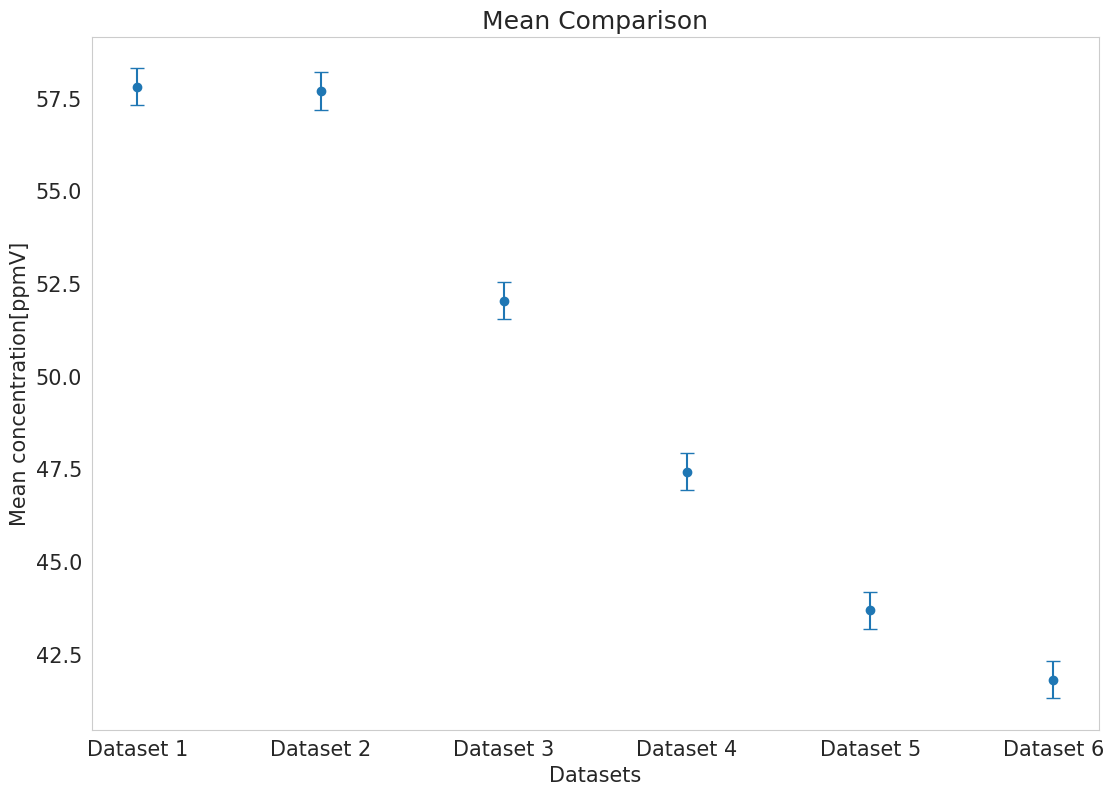

In [8]:
xLabel="Datasets"
yLabel="Mean concentration[ppmV]" 
dimensionless="False"
xAchse = None 
yAchse=None #(72,79) #None 
error_values=0.5 #[0.5,0.2,0.1] #For error values overgive one number which is cast to all values, or an array if specify different errors for each measurements
errorType="absolute"
test = create_means(DataPointsConc,error_values,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=xAchse,yAchse=yAchse)
#plt.savefig("Mean_comparison.png",test) #To save image

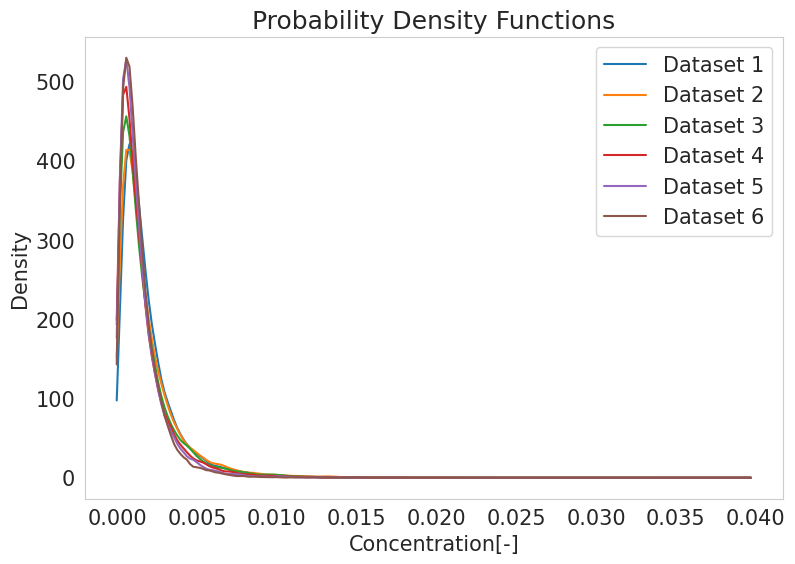

In [9]:
xLabel="Concentration[-]"
yLabel="Density"
dimensionless="True"
create_pdf(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

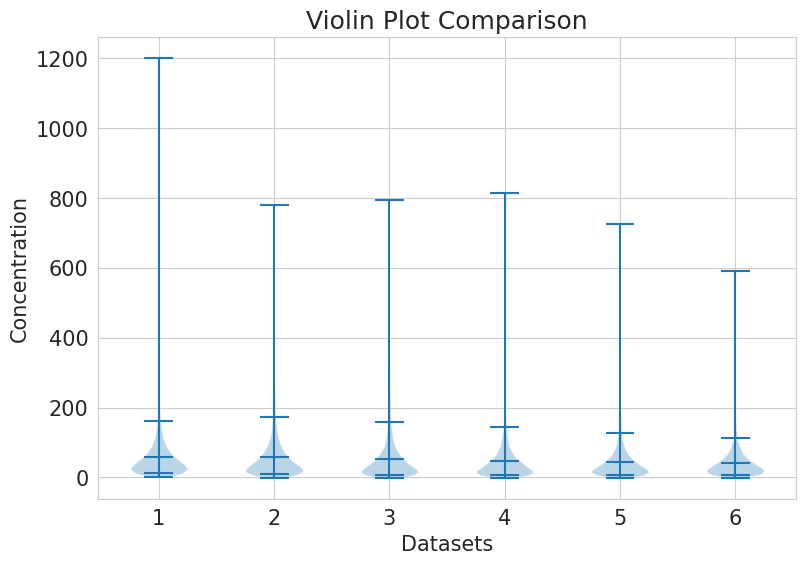

In [10]:
xLabel="Datasets"
yLabel="Concentration [-]"
dimensionless="True"
create_violinplot(DataPointsConc)

AttributeError: module 'matplotlib.pyplot' has no attribute 'get_xticklabels'

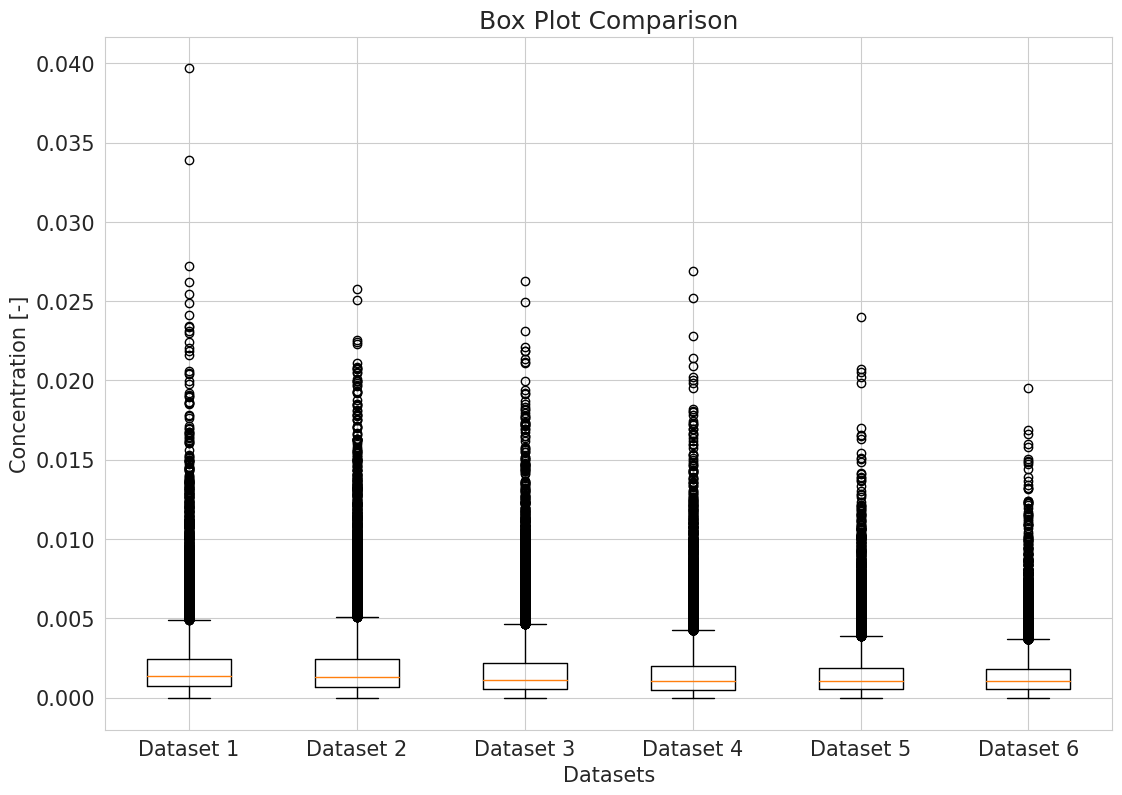

In [11]:
xLabel="Datasets"
yLabel="Concentration [-]"
dimensionless="True"
create_boxplot(DataPointsConc,dimensionless="True",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

In [ ]:
xLabel="Datasets"
yLabel="Concentration[ppmV]"
xLabel="Datasets"
yLabel="Concentration[ppmV]"
create_histogram(DataPointsConc,dimensionless="False",labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

In [ ]:
yLabel=None
xLabel="Concentration[-]"
dimensionless="False"
create_cdf(DataPointsConc,dimensionless=dimensionless,labels=None,xLabel=xLabel,yLabel=yLabel,xAchse=None,yAchse=None)

In [ ]:
test = powerDensityPlot(DataPointsConc,dimensionless="False",plot=True,labels=None,xLabel=None,yLabel=None,xAchse=None,yAchse=None)
plt.savefig("test.png",test)

In [ ]:
from windtunnel.concentration.CompareDatasets import compare_point_concentrations_3
#Give overview/comparison for the data, one plot including of of the plots choosen in the list "functionsForOverview
#Means, Pdf, Cdf, PowerDensity: Number of ts does not matter that much
#Scatterplot: use only 2 ts
#Histogram, Boxplot: would also recommend not to many, because of overlapping of the histograms for comparison, space for the boxplots..

#functionsForOverview = ["all"] #defaul -> all of the available plots
#all_plot_types = [
#        "Histogram", "Pdf", "Cdf", "Means", "BoxPlot", 
#        "QuantilPlot", "ScatterPlot", "ResidualPlot", "Autocorrelation"
#    ]
    
functionsForOverview = [
    "Histogram",
    "BoxPlot"
    #"",
    "Pdf",
    "Cdf",
    "Means",
    "PowerDensity"
        ]

#Choose which concentration time series/PointObjekts to show in the overview/comparison plot
DataPointsConc = [
    conc_ts[namelist[0]][files[0]],#
    conc_ts[namelist[0]][files[1]],
    #conc_ts[namelist[0]][files[2]],
    #conc_ts[namelist[0]][files[3]],
    #conc_ts[namelist[0]][files[4]],
    #conc_ts[namelist[0]][files[5]]
]

compare_point_concentrations_3(DataPointsConc,functionsForOverview)

In [ ]:
#Concentration fluctuation analysis 
#Intermittency based on threshold, peak2Mean, concentration variance spectral density distribution

#Seettings intermittency calculation
threshold_type="ratio" #ratio, absolute
threshold_method="mean" #mean, std
intermittency_threshold=1.5 #-> if type=ratio,method mean, threshold=threshold*mean(concentration), if type=absolute: threshold=threshold

for name in namelist:
    for file in files:
        conc_ts[name][file].analyze_concentration_fluctuations(dimensionless="False",
                                                       intermittency_threshold=intermittency_threshold,threshold_method=threshold_method)
#power(variance) of concentration changes for different frequencies/timer interval lengths 
#Low-frequency peak: Slow, gradual concentration changes
#High-frequency peak: Rapid, quick concentration fluctuations
#Broad spectrum: Mixed or complex concentration dynamics

In [ ]:
#For completeness also calculate further characteristic metrics of flow/ wind velocity time series (from wtref ts), skewness ..
#print(conc_ts[name][file].calculate_turbulence_intensity(dimensionless="True",returnDistribution="False",returnMetrics="True"))